BUG RELATED QUESTIONS
- Book problem
- Input problem: torque, WSG, etc.
- Simulation dies?
- Control of WSG
- Why does the simulation stop when I add point clouds (this is when we find the antipodal grasp)?
- How to deal with context: keep one context all the time? What is the best way of dealing with this?
- Station input port seeming to have 20 variables as opposed to 12 (https://piazza.com/class/lm1wm4iwue34wl/post/526)
- Simulation time being slow and also rendering issues with point cloud being the only thing that's updating when we try to simulate our trajectory

EXPERIMENTAL CODE QUESTIONS
- Planner: how to design the planner? Is that design the right approach?
- Perception: more than one book? Get ICP for more than one book? How do we segment the point cloud?
- IK/DiffIK: how do we fix the z-coord in the base?

## Generating and Visualizing Antipodal Grasps on Book

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import trimesh
import sys
from typing import List 
from IPython.display import clear_output
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Concatenate,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Parser,
    PointCloud,
    RigidTransform,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
    Context,
    Diagram,
    PointCloud,
    Simulator,
    TrajectorySource,
    Solve,
    RotationMatrix,
    MultibodyPlant,
    eq,
    StateInterpolatorWithDiscreteDerivative,
    MinimumDistanceLowerBoundConstraint,
    RollPitchYaw,
    SolutionResult,
    CollisionFilterDeclaration,
    GeometrySet,
    Role,
)
from pydrake.geometry import Meshcat
from pydrake.multibody import inverse_kinematics

from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation import running_as_notebook
from manipulation.scenarios import AddFloatingRpyJoint, AddRgbdSensors, ycb, AddMultibodyTriad, MakeManipulationStation
from manipulation.utils import ConfigureParser
from manipulation.clutter import GraspCandidateCost, GenerateAntipodalGraspCandidate
from manipulation.icp import IterativeClosestPoint
from manipulation.pick import (
    MakeGripperCommandTrajectory,
    MakeGripperFrames,
    MakeGripperPoseTrajectory,
)
# Own utils
from hwstation.utils import init_diagram, fix_input_port, visualize_diagram
from hwstation.add_objects import get_library_scenario_data, get_library_scenario_data_without_robot

from enum import Enum
import pandas as pd

In [3]:
def filterCollsionGeometry(scene_graph, context=None):
    """Some robot models may appear to have self collisions due to overlapping collision geometries.
    This function filters out such problems for our PR2 model."""
    if context is None:
        filter_manager = scene_graph.collision_filter_manager()
    else:
        filter_manager = scene_graph.collision_filter_manager(context)
    inspector = scene_graph.model_inspector()

    book = {}
    shelf = {}
    table = {}

    for gid in inspector.GetGeometryIds(
        GeometrySet(inspector.GetAllGeometryIds()), Role.kProximity
    ):
        gid_name = inspector.GetName(inspector.GetFrameId(gid))

        if "book" in gid_name:
            link_name = gid_name.split("::")[1]
            book[link_name] = [gid]

        if "table" in gid_name:
            link_name = gid_name.split("::")[1]
            table[link_name] = [gid]

        if "shelf" in gid_name:
            link_name = gid_name.split("::")[1]
            shelf[link_name] = [gid]

    def add_exclusion(set1, set2=None):
        if set2 is None:
            filter_manager.Apply(
                CollisionFilterDeclaration().ExcludeWithin(GeometrySet(set1))
            )
        else:
            filter_manager.Apply(
                CollisionFilterDeclaration().ExcludeBetween(
                    GeometrySet(set1), GeometrySet(set2)
                )
            )

    # Exclude collisions between book and table
    for _, book_ids in book.items():
        for _, table_piece_ids in table.items():
            add_exclusion(
                table_piece_ids, book_ids
            )

    # Exclude collisions between book and shelf
    for _, book_ids in book.items():
        for _, shelf_piece_ids in shelf.items():
            add_exclusion(
                shelf_piece_ids, book_ids
            )


## 1. Setup environment

In [4]:
# Start meshcat
try:
    meshcat = Meshcat(7005)
except:
    pass #This error appears if this cell is executed twice (port 7006 is already taken then)

scenario_data = get_library_scenario_data()
diagram, visualizer, simulator = init_diagram(meshcat, scenario_data)
fix_input_port(diagram, simulator)
diagram_context = diagram.CreateDefaultContext()
scene_graph = diagram.GetSubsystemByName("station").GetSubsystemByName("scene_graph")
sg_context = scene_graph.GetMyContextFromRoot(diagram_context)
filterCollsionGeometry(scene_graph, sg_context)
simulator.AdvanceTo(1.0)

INFO:drake:Meshcat listening for connections at http://localhost:7005


Station input port size:  <pydrake.systems.framework.InputPort object at 0x7fff8cb9a4f0>
plant.GetStateNames():  37
plant.GetActuatorNames():  12
Fixing input port of size:  20
Fixing input port of size:  1


## 2. ICP for book point cloud

Pointcloud Related Functions (to be used when finding point cloud to do grasp)

In [5]:
def get_table_pointclouds(diagram_context: Context, diagram: Diagram):
    point_cloud_dict = {}
    for idx in range(4):
        point_cloud_dict[f"table_camera_{idx}_ptcloud"] = diagram.GetOutputPort(f"table_camera_{idx}_ptcloud").Eval(diagram_context)
    return point_cloud_dict


def merge_point_clouds(table_pointclouds: dict, 
                        downsample_factor: float = 0.005,
                        lower_xyz: List[float] = [0.0, -0.2, 0.5564], 
                        upper_xyz: List[float] = [0.75, 1.5, 0.8]):
    pcd = []
    for key in table_pointclouds.keys():
        cloud = table_pointclouds[key]
        pcd.append(
            cloud.Crop(lower_xyz=lower_xyz, upper_xyz=upper_xyz)
            )
    merged_pcd = Concatenate(pcd)
    down_sampled_pcd = merged_pcd.VoxelizedDownSample(voxel_size=0.005)
    return down_sampled_pcd

def get_merged_pointcloud(diagram_context: Context, diagram: Diagram):
    
    #Get merged point cloud from all cameras:
    table_pointclouds = get_table_pointclouds(diagram_context, diagram)
    merged_pcd = merge_point_clouds(table_pointclouds)

    #Ensure that all number are finite:
    merged_pcd_np = merged_pcd.xyzs().transpose()
    mask_points = (merged_pcd_np== np.inf).all(axis=1)
    if mask_points.any():
        sys.exit("No infinite points were expected")
    return merged_pcd

def convert_obj_to_pc(filename: str, n_samples: int = 10000, show: bool =False) -> np.ndarray:
    book_mesh = trimesh.load(filename)
    book_hull = book_mesh.convex_hull
    sample_points = book_hull.sample(n_samples)
    point_cloud = trimesh.points.PointCloud(sample_points)
    if show:
        scene = trimesh.Scene([book_hull, point_cloud])
        scene.show()
    return np.array(point_cloud.vertices).transpose()

## 3. Finding and Visualizing the Gripper Grasp Poses

### 3.1. Running ICP to find point cloud

In [6]:
def run_table_book_icp(diagram, diagram_context):
    
    # Point clouds to obtain the cloud we will work with for grasps:
    scene_pcl = get_merged_pointcloud(diagram_context, diagram)
    meshcat.SetObject("merged_cropped_pcl", cloud=scene_pcl, point_size=0.004)

    book_filename = "hwstation/objects/book.obj"
    model_pcl = convert_obj_to_pc(book_filename, show=False)

    height_table = 0.5
    initial_guess = RigidTransform(p=[0.0,0.0,height_table])

    X_MS_hat, chat = IterativeClosestPoint(
        p_Om=model_pcl,
        p_Ws=scene_pcl.xyzs(),
        X_Ohat=initial_guess,
        meshcat=meshcat,
        meshcat_scene_path="icp",
        max_iterations=45,
    )

    transformed_model_pcl = X_MS_hat @ model_pcl

    cloud = PointCloud(transformed_model_pcl.shape[1])
    cloud.mutable_xyzs()[:] = transformed_model_pcl
    cloud.EstimateNormals(radius=0.5, num_closest=50)

    return cloud, X_MS_hat

In [7]:
icp_cloud, X_MS_hat = run_table_book_icp(diagram, diagram_context)

fixing improper rotation


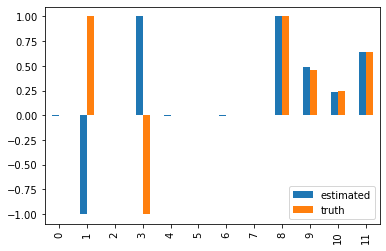

In [8]:
def check_quality_of_icp():
    plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    book_frame = plant.GetFrameByName("book")
    X_book = book_frame.CalcPoseInWorld(plant_context)
    Rot_est = X_MS_hat.rotation().matrix().flatten()
    trans_est = X_MS_hat.translation().flatten()
    Rot_truth = X_book.rotation().matrix().flatten()
    trans_truth = X_book.translation().flatten()
    est = np.concatenate([Rot_est,trans_est])
    truth = np.concatenate([Rot_truth,trans_truth])
    pd.DataFrame({"estimated": est, "truth": truth}).plot(kind='bar')
check_quality_of_icp()


### 3.2. Sampling and Evaluting Grasp Poses

In [9]:
def make_internal_model():
    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    ConfigureParser(parser)

    parser.AddModelsFromUrl("file:///workspaces/RobotLibrarian/hwstation/objects/library_setup_floating_gripper.dmd.yaml")
    plant.Finalize()

    return builder.Build()

In [10]:
def sample_grasps(cloud: PointCloud, diagram: Diagram, diagram_context: Context):
    rng = np.random.default_rng()
    # Now find grasp poses
    # X_Gs will have the poses to be used for planning when working on that step
    internal_model = make_internal_model()
    internal_model_context = internal_model.CreateDefaultContext()
    costs = []
    X_Gs = []
    for i in range(100 if running_as_notebook else 2):
        cost, X_G = GenerateAntipodalGraspCandidate(
            internal_model, internal_model_context, cloud, rng
        )
        if np.isfinite(cost):
            costs.append(cost)
            X_Gs.append(X_G)

    indices = np.asarray(costs).argsort()[:5]
    min_cost_XGs = []
    for idx in indices:
        min_cost_XGs.append(X_Gs[idx])

    #Get the antipodal grasp that is closest to the robot WSG frame:
    positions = np.stack([frame.translation() for frame in min_cost_XGs])

    plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(diagram_context)

    wsg = plant.GetBodyByName("body")
    wsg_body_index = wsg.index()

    wsg_pose = plant.EvalBodyPoseInWorld(plant_context,wsg)
    wsg_position = wsg_pose.translation()

    best_grasp_idx = np.argmin(((positions-wsg_position)**2).sum(axis=1))
    X_G_optim = min_cost_XGs[best_grasp_idx]

    return X_G_optim

In [11]:
optim_grasp = sample_grasps(icp_cloud, diagram, diagram_context)
optim_grasp

RigidTransform(
  R=RotationMatrix([
    [0.9746200535324092, 0.1166742975306446, -0.19105721537857245],
    [0.22310868020153926, -0.5763521049501004, 0.7861556893760393],
    [-0.018392065441675917, -0.808829623230578, -0.5877553679154874],
  ]),
  p=[0.4603640457488859, 0.3566906462405768, 0.7277698185311221],
)

## 4. Trajectory Planning with RRT

In [12]:
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.station import AddPointClouds
#from manipulation.pick import *

In [13]:
class ManipulationStationSim:
    def __init__(self, diagram: Diagram, diagram_context: Context):
        self.diagram = diagram
        self.station = diagram.GetSubsystemByName("station")
        self.plant = self.station.GetSubsystemByName("plant")
        self.scene_graph = self.station.GetSubsystemByName("scene_graph")

        # scene graph query output port.
        self.query_output_port = self.scene_graph.GetOutputPort("query")

        # contexts
        self.context_diagram = diagram_context
        self.context_station = self.diagram.GetSubsystemContext(
            self.station, self.context_diagram
        )
        self.context_scene_graph = self.station.GetSubsystemContext(
            self.scene_graph, self.context_station
        )
        self.context_plant = self.station.GetMutableSubsystemContext(
            self.plant, self.context_station
        )
        # # mark initial configuration
        # self.q0 = self.plant.GetPositions(
        #     self.context_plant, self.plant.GetModelInstanceByName("mobile_iiwa")
        # )

    def SetStationConfiguration(
        self, q_iiwa, gripper_setpoint
    ):
        """
        :param q_iiwa: (10,) numpy array, base pos and joint angle of robots in radian.
        :param gripper_setpoint: float, gripper opening distance in meters.
        :return:
        """
        self.plant.SetPositions(
            self.context_plant,
            self.plant.GetModelInstanceByName("mobile_iiwa"),
            q_iiwa,
        )
        self.plant.SetPositions(
            self.context_plant,
            self.plant.GetModelInstanceByName("wsg"),
            [-gripper_setpoint / 2, gripper_setpoint / 2],
        )

    def ExistsCollision(
        self, q_iiwa, gripper_setpoint):
        self.SetStationConfiguration(
            q_iiwa, gripper_setpoint
        )
        query_object = self.query_output_port.Eval(self.context_scene_graph)
        collision_pairs = query_object.ComputePointPairPenetration()
        return len(collision_pairs) > 0

In [14]:
# scenario_data = get_library_scenario_data()
# meshcat.Delete()
# builder = DiagramBuilder()
# scenario = load_scenario(data=scenario_data)
# station = builder.AddSystem(MakeHardwareStation(scenario, meshcat,parser_preload_callback=ConfigureParser))

# # Adding point cloud extractors:
# to_point_cloud = AddPointClouds(
#     scenario=scenario, station=station, builder=builder, meshcat=meshcat
# )

# manipSim = ManipulationStationSim(diagram, diagram_context)

In [15]:
from rrt_planner_helpers.rrt_planning import (
    Problem,
)
from rrt_planner_helpers.robot import (
    ConfigurationSpace,
    Range,
)

In [16]:
class IKSolver(object):
    def __init__(self):

        # setup controller plant
        plant_mobile_iiwa = MultibodyPlant(0.0)
        iiwa_file = "file:///workspaces/RobotLibrarian/hwstation/objects/mobile_iiwa14_primitive_collision.urdf"
        iiwa = Parser(plant_mobile_iiwa).AddModelsFromUrl(iiwa_file)[0]

        # Define frames
        L0 = plant_mobile_iiwa.GetFrameByName("base")
        l7_frame = plant_mobile_iiwa.GetFrameByName("iiwa_link_7")
        world_frame = plant_mobile_iiwa.world_frame()
        plant_mobile_iiwa.WeldFrames(world_frame, L0)
        plant_mobile_iiwa.Finalize()
        plant_mobile_context = plant_mobile_iiwa.CreateDefaultContext()

        # gripper in link 7 frame
        X_L7G = RigidTransform(
            rpy=RollPitchYaw([np.pi / 2, 0, np.pi / 2]), p=[0, 0, 0.114]
        )
        world_frame = plant_mobile_iiwa.world_frame()

        self.world_frame = world_frame
        self.l7_frame = l7_frame
        self.plant_iiwa = plant_mobile_iiwa
        self.plant_context = plant_mobile_context
        self.X_L7G = X_L7G

    def solve(self, X_WT, q_guess=None, theta_bound=0.01, position_bound=0.01):
        """
        plant: a mini plant only consists of iiwa arm with no gripper attached
        X_WT: transform of target frame in world frame
        q_guess: a guess on the joint state sol
        """
        plant_mobile_iiwa = self.plant_iiwa
        l7_frame = self.l7_frame
        X_L7G = self.X_L7G
        world_frame = self.world_frame

        R_WT = X_WT.rotation()
        p_WT = X_WT.translation()

        if q_guess is None:
            q_guess = np.zeros(10)

        ik_instance = inverse_kinematics.InverseKinematics(plant_mobile_iiwa)
        # align frame A to frame B
        ik_instance.AddOrientationConstraint(
            frameAbar=l7_frame,
            R_AbarA=X_L7G.rotation(),
            #   R_AbarA=RotationMatrix(), # for link 7
            frameBbar=world_frame,
            R_BbarB=R_WT,
            theta_bound=position_bound,
        )
        # align point Q in frame B to the bounding box in frame A
        ik_instance.AddPositionConstraint(
            frameB=l7_frame,
            p_BQ=X_L7G.translation(),
            # p_BQ=[0,0,0], # for link 7
            frameA=world_frame,
            p_AQ_lower=p_WT - position_bound,
            p_AQ_upper=p_WT + position_bound,
        )
        prog = ik_instance.prog()
        prog.SetInitialGuess(ik_instance.q(), q_guess)
        result = Solve(prog)
        if result.get_solution_result() != SolutionResult.kSolutionFound:
            return result.GetSolution(ik_instance.q()), False
        return result.GetSolution(ik_instance.q()), True

In [17]:
plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")
plant_context = plant.GetMyContextFromRoot(diagram_context)
q0 = plant.GetPositions(
            plant_context, plant.GetModelInstanceByName("mobile_iiwa")
        )

ik_solver = IKSolver()
q_goal, optimal = ik_solver.solve(optim_grasp, q_guess=q0)

In [18]:
class IiwaProblem(Problem):
    def __init__(
        self,
        q_start: np.array,
        q_goal: np.array,
        gripper_setpoint: float,
        collision_checker: ManipulationStationSim,
        debug: bool = False,
    ):
        self.gripper_setpoint = gripper_setpoint
        self.collision_checker = collision_checker
        plant = self.collision_checker.plant
        nq = 10
        joint_limits = np.zeros((nq, 2))
        
        #DEBUG: remove z
        for idx,joint_char in enumerate(["x","y","z"]):
            joint = plant.GetJointByName("iiwa_base_"+joint_char)
            joint_limits[idx, 0] = joint.position_lower_limits()
            joint_limits[idx, 1] = joint.position_upper_limits()
        
        # joint = plant.GetJointByName("iiwa_joint_z")
        # joint_limits[2, 0] = 0.0
        # joint_limits[2, 1] = 0.0

        for i in range(3,nq):
            joint = plant.GetJointByName("iiwa_joint_%i" % (i-2))
            joint_limits[i, 0] = joint.position_lower_limits()
            joint_limits[i, 1] = joint.position_upper_limits()

        range_list = []
        for joint_limit in joint_limits:
            range_list.append(Range(joint_limit[0], joint_limit[1]))
        #print(range_list)
        def l2_distance(q: tuple):
            sum = 0
            for q_i in q:
                sum += q_i**2
            return np.sqrt(sum)
        self.joint_limits = joint_limits
        max_steps = nq * [np.pi / 180 * 2]  # three degrees
        cspace_iiwa = ConfigurationSpace(range_list, l2_distance, max_steps)
        self.joint_limits = joint_limits

        #Call base class constructor.
        Problem.__init__(
            self,
            x=10,  # not used.
            y=10,  # not used.
            robot=None,  # not used.
            obstacles=None,  # not used.
            start=tuple(q_start),
            goal=tuple(q_goal),
            cspace=cspace_iiwa,
            debug=debug
        )

    def collide(self, configuration):
        q = np.array(configuration)
        return self.collision_checker.ExistsCollision(
            q,
            self.gripper_setpoint,
        )

In [19]:
# manipSim = ManipulationStationSim(diagram, diagram_context)

# gripper_setpoint = 0.1

# #  IF THIS FAILS NEED TO RERUN ICP AND GET A NEW OPTIMAL GRASP
# iiwa_problem = IiwaProblem(
#     q_start=q0,
#     q_goal=q_goal,
#     gripper_setpoint=gripper_setpoint,
#     collision_checker=manipSim,
#     debug=True,
# )

In [20]:
from random import random

In [21]:
class TreeNode:
    def __init__(self, value, parent=None):
        self.value = value  # tuple of floats representing a configuration
        self.parent = parent  # another TreeNode
        self.children = []  # list of TreeNodes

class RRT:
    """
    RRT Tree.
    """

    def __init__(self, root: TreeNode, cspace: ConfigurationSpace):
        self.root = root  # root TreeNode
        self.cspace = cspace  # robot.ConfigurationSpace
        self.size = 1  # int length of path
        self.max_recursion = 1000  # int length of longest possible path

    def add_configuration(self, parent_node, child_value):
        child_node = TreeNode(child_value, parent_node)
        parent_node.children.append(child_node)
        self.size += 1
        return child_node

    # Brute force nearest, handles general distance functions
    def nearest(self, configuration):
        """
        Finds the nearest node by distance to configuration in the
             configuration space.

        Args:
            configuration: tuple of floats representing a configuration of a
                robot

        Returns:
            closest: TreeNode. the closest node in the configuration space
                to configuration
            distance: float. distance from configuration to closest
        """

        configuration = np.nan_to_num(configuration) # had to add this line to make it work
        assert self.cspace.valid_configuration(configuration)

        def recur(node, depth=0):
            closest, distance = node, self.cspace.distance(
                node.value, configuration
            )
            if depth < self.max_recursion:
                for child in node.children:
                    (child_closest, child_distance) = recur(child, depth + 1)
                    if child_distance < distance:
                        closest = child_closest
                        child_distance = child_distance
            return closest, distance

        return recur(self.root)[0]

In [22]:
class RRT_tools:
    def __init__(self, problem):
        # rrt is a tree
        self.rrt_tree = RRT(TreeNode(problem.start), problem.cspace)
        problem.rrts = [self.rrt_tree]
        self.problem = problem

    def find_nearest_node_in_RRT_graph(self, q_sample):
        nearest_node = self.rrt_tree.nearest(q_sample)
        return nearest_node

    def sample_node_in_configuration_space(self):
        q_sample = self.problem.cspace.sample()
        return q_sample

    def calc_intermediate_qs_wo_collision(self, q_start, q_end):
        """create more samples by linear interpolation from q_start
        to q_end. Return all samples that are not in collision

        Example interpolated path:
        q_start, qa, qb, (Obstacle), qc , q_end
        returns >>> q_start, qa, qb
        """
        return self.problem.safe_path(q_start, q_end)

    def grow_rrt_tree(self, parent_node, q_sample):
        """
        add q_sample to the rrt tree as a child of the parent node
        returns the rrt tree node generated from q_sample
        """
        child_node = self.rrt_tree.add_configuration(parent_node, q_sample)
        return child_node

    def node_reaches_goal(self, node):
        return node.value == self.problem.goal

    def backup_path_from_node(self, node):
        path = [node.value]
        while node.parent is not None:
            node = node.parent
            path.append(node.value)
        path.reverse()
        return path

In [23]:
def rrt_planning(problem, max_iterations=1000, prob_sample_q_goal=0.05):
    """
    Input:
        problem (IiwaProblem): instance of a utility class
        max_iterations: the maximum number of samples to be collected
        prob_sample_q_goal: the probability of sampling q_goal

    Output:
        path (list): [q_start, ...., q_goal].
                    Note q's are configurations, not RRT nodes
    """
    rrt_tools = RRT_tools(iiwa_problem)
    q_goal = problem.goal
    q_start = problem.start

    for k in range(max_iterations):
        q_sample = rrt_tools.sample_node_in_configuration_space()
        rand = random()
        if rand < prob_sample_q_goal:
            q_sample = q_goal
        nearest_node = rrt_tools.find_nearest_node_in_RRT_graph(q_sample)
        q_list = rrt_tools.calc_intermediate_qs_wo_collision(nearest_node.value, q_sample)

        last_node = nearest_node
        for q_i in q_list:
            last_node = rrt_tools.grow_rrt_tree(last_node, q_i)
        

        path_found = rrt_tools.node_reaches_goal(last_node)
        if hasattr(path_found, "__len__"):
            path_found = all(rrt_tools.node_reaches_goal(last_node))
        
        if path_found:
            path = rrt_tools.backup_path_from_node(last_node)
            return path

    return None

In [24]:
from manipulation.pick import *

In [25]:
def get_table_wsg_poses(diagram: Diagram, diagram_context: Context):

    plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")
    
    wsg = plant.GetBodyByName("body")
    wsg_body_index = wsg.index()
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    wsg_initial_pose = plant.EvalBodyPoseInWorld(plant_context,wsg)
    
    X_G_dict = {"initial":  wsg_initial_pose, "pick": optim_grasp, "place": wsg_initial_pose}
    
    return X_G_dict

def create_gripper_pose_and_command_trajectories(X_G_dict):
    traj_frames, traj_times = MakeGripperFrames(X_G_dict)
    trajectory = MakeGripperPoseTrajectory(traj_frames,traj_times)
    traj_wsg_command = MakeGripperCommandTrajectory(traj_times)
    return traj_times, trajectory, traj_wsg_command

In [26]:
manipSim = ManipulationStationSim(diagram, diagram_context)

In [27]:
gripper_setpoint = 0.1

#  IF THIS FAILS NEED TO RERUN ICP AND GET A NEW OPTIMAL GRASP
iiwa_problem = IiwaProblem(
    q_start=q0,
    q_goal=q_goal,
    gripper_setpoint=gripper_setpoint,
    collision_checker=manipSim,
    debug=True,
)

path = rrt_planning(iiwa_problem, 600, 0.05)
if path is None:
    sys.exit("Failed to find a path")
max_time = 5.0
t_lst = np.linspace(0, max_time, len(path))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, np.array(path).T)

# just trying to have a gripper trajectory so I can run this (this line breaks when trying to rerun because the context is gone so we'll need something better)
X_G_dict = get_table_wsg_poses(diagram, diagram_context)
traj_times, trajectory, traj_wsg_command = create_gripper_pose_and_command_trajectories(X_G_dict)

self.collide:  False
self.valid configuration:  True
self.collide:  False
self.valid configuration:  True


/tmp/ipykernel_14452/2286333257.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  joint_limits[idx, 0] = joint.position_lower_limits()
/tmp/ipykernel_14452/2286333257.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  joint_limits[idx, 1] = joint.position_upper_limits()
/tmp/ipykernel_14452/2286333257.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  joint_limits[i, 0] = joint.position_lower_limits()
/tmp/ipykernel_14452/2286333257.py:29: DeprecationWarning

In [30]:
scenario_data = get_library_scenario_data()
meshcat.Delete()
builder = DiagramBuilder()
scenario = load_scenario(data=scenario_data)
station = builder.AddSystem(MakeHardwareStation(scenario, meshcat,parser_preload_callback=ConfigureParser))

# Adding point cloud extractors:
to_point_cloud = AddPointClouds(
    scenario=scenario, station=station, builder=builder, meshcat=meshcat
)

#Connect point clouds with output port:
for idx, name in enumerate(to_point_cloud.keys()):
    builder.ExportOutput(
        to_point_cloud[name].get_output_port(), name+"_ptcloud")

builder.ExportOutput(
    station.GetOutputPort("mobile_iiwa.state_estimated"),
    "mobile_iiwa.state_estimated"
)

# builder.ExportInput(
#     station.GetInputPort("mobile_iiwa.desired_state"),
#     "mobile_iiwa.desired_state"
# )

q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
g_traj_system = builder.AddSystem(TrajectorySource(traj_wsg_command))

state_interpolator = builder.AddSystem(StateInterpolatorWithDiscreteDerivative(num_positions=10, time_step=0.1))

# builder.Connect(
#     q_traj_system.get_output_port(), station.GetInputPort("mobile_iiwa.desired_state")
# )

builder.Connect(
    q_traj_system.get_output_port(), state_interpolator.GetInputPort("position")
)

builder.Connect(
    state_interpolator.GetOutputPort("state"), station.GetInputPort("mobile_iiwa.desired_state")
)

builder.Connect(
    g_traj_system.get_output_port(), station.GetInputPort("wsg.position")
)


visualizer = MeshcatVisualizer.AddToBuilder(builder, station.GetOutputPort("query_object"), meshcat)
diagram = builder.Build()
#diagram.set_name("plant and scene_graph")
diagram_context = diagram.CreateDefaultContext()
scene_graph = diagram.GetSubsystemByName("station").GetSubsystemByName("scene_graph")
sg_context = scene_graph.GetMyContextFromRoot(diagram_context)
filterCollsionGeometry(scene_graph, sg_context)

simulator = Simulator(diagram)
#fix_input_port(diagram, simulator)
#visualizer.StartRecording(False)
simulator.AdvanceTo(10.0)

: 

## CODE BELOW THIS POINT IS EXPERIMENTAL

In [ ]:
class PlannerState(Enum):
    WAIT_FOR_OBJECTS_TO_SETTLE = 1
    GRASPING_BOOK_ON_TABLE = 2
    GOING_TO_SHELF = 3
    PLACING_BOOK_ON_SHELF = 4
    GO_BACK_TO_TABLE = 5

In [ ]:
class Planner(LeafSystem):
    
    """A Planner system.

    Input Ports:
    - body_poses: RigidTransforms given the desired frame of the gripper
    - table_book_grasp: (cost,RigidTransform) giving the desired frame to grasp a book on the table
    - shelf_book_grasp: (cost, RididTransform) giving the desired frame to put a book on the shelf
    - wsg_state: a vector of size 2 giving the WSG commands (I supose each fingers position)
    - iiwa_joints: a vector of size 7 for joint positions
    - iiwa_base: a vector of size 2 for x- and y- coordinates of base

    States:
    - self._mode_index: current mode of the planner
    - self._traj_X_G_index: trajectory of gripper frame
    - self._traj_wsg_index: command trajectory of WSG fingers?
    - self._times_index: dictionary of times
    - self._attempts_index: attempts of grasping something

    Output ports:
    - 
    -
    -
    """

    def __init__(self, plant):
        LeafSystem.__init__(self)

        self._gripper_body_index = plant.GetBodyByName("body").index()
        
        #********
        #Declare input ports
        #********
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()])
        )
        self._table_book_grasp_index = self.DeclareAbstractInputPort(
            "table_book_grasp", AbstractValue.Make((np.inf, RigidTransform()))
        ).get_index()

        self._shelf_book_grasp_index = self.DeclareAbstractInputPort(
            "shelf_book_grasp", AbstractValue.Make((np.inf, RigidTransform()))
        ).get_index()

        #Declares a vector-valued input port of size 2:
        self._wsg_state_index = self.DeclareVectorInputPort(
            "wsg_state", 2
        ).get_index()

        # For GoHome mode.
        num_iiwa_actuators = 10
        self._iiwa_actuators_index = self.DeclareVectorInputPort(
            "iiwa_actuators", num_iiwa_actuators
        ).get_index()

        #********
        #Declare states of the system
        #********

        #Abstract state giving the mode:
        #A Context obtained with CreateDefaultContext() will contain this abstract state 
        #variable initially set to a clone of the model_value given here. The actual concrete 
        # type is always preserved.
        self._mode_index = self.DeclareAbstractState(
            AbstractValue.Make(PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE)
        )
        self._q_traj_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial())
        )
        self._traj_wsg_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial())
        )
        self._times_index = self.DeclareAbstractState(
            AbstractValue.Make({"initial": 0.0})
        )
        #Declares a discrete state group with num_state_variables state variables, 
        #stored in a BasicVector initialized to be all-zero.
        self._attempts_index = self.DeclareDiscreteState(1)

        #********
        #Declare output ports of the system
        #********
        # self.DeclareAbstractOutputPort(
        #     "X_WG",
        #     lambda: AbstractValue.Make(RigidTransform()),
        #     self.CalcGripperPose)

        # self.DeclareVectorOutputPort("wsg_position", 1, self.CalcWsgPosition)

        # self.DeclareAbstractOutputPort(
        #     "control_mode",
        #     lambda: AbstractValue.Make(InputPortIndex(0)),
        #     self.CalcControlMode,
        # )

        # self.DeclareAbstractOutputPort(
        #     "reset_diff_ik",
        #     lambda: AbstractValue.Make(False),
        #     self.CalcDiffIKReset,
        # )

        # self._q0_index = self.DeclareDiscreteState(num_positions)  # for q0
        # self._traj_q_index = self.DeclareAbstractState(
        #     AbstractValue.Make(PiecewisePolynomial())
        # )

        self.DeclareVectorOutputPort(
            "iiwa_command", 10, self.CalcIiwa
        )

        #********
        #Declare initialization
        #********
        self.DeclareInitializationDiscreteUpdateEvent(self.Initialize)

        #********
        #Declare periodic updates
        #********
        # Declares that an UnrestrictedUpdate event should occur periodically and 
        # that it should invoke the Update method every 0.1 second at 0.0 offset
        self.DeclarePeriodicUnrestrictedUpdateEvent(0.1, 0.0, self.Update)

    def Update(self, context, state):
        """Function to updates the mode what we are doing. We do not update the output here 
        - just the state (calling plan if something goes wrong)"""

        #Derive what mode we are in:
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        # Get time:
        current_time = context.get_time()

        # Get all "milestone" times:
        times = context.get_abstract_state(int(self._times_index)).get_value()

        #Wait for objects to settle:
        if mode == PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE:
            # Are we more than 1s past the initial time? If yes, move on:
            if context.get_time() - times["initial"] > 1.0:
                self.Plan(context, state)
            return
        
        elif mode == PlannerState.GO_HOME:
            sys.exit("GOING HOME IS NOT IMPLEMENTED YET.")
            # traj_q = context.get_mutable_abstract_state(
            #     int(self._traj_q_index)
            # ).get_value()
            # if not traj_q.is_time_in_range(current_time):
            #     self.Plan(context, state)
            return

        # If we are between pick and place and the gripper is closed, then
        # we've missed or dropped the object.  Time to replan.
        if (
            current_time > times["postpick"]
            and current_time < times["preplace"]
        ):
            pass
            # Get teh state of the WSG
            # wsg_state = self.get_input_port(self._wsg_state_index).Eval(
            #     context
            # )
            # Check if WSG is closed all the way (no objects between fingers)
            # if wsg_state[0] < 0.01:
            #     attempts = state.get_mutable_discrete_state(
            #         int(self._attempts_index)
            #     ).get_mutable_value()
            #     if attempts[0] > 10:
            #         sys.exit("More than 10 attempts.")
            #     attempts[0] += 1

            #     # Reset to starting point to start anew
            #     state.get_mutable_abstract_state(
            #         int(self._mode_index)
            #     ).set_value(PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE)
            #     times = {"initial": current_time}
            #     state.get_mutable_abstract_state(
            #         int(self._times_index)
            #     ).set_value(times)

            #     # Stop moving and stay where u are
            #     #DEBUG HERE:
            #     X_G = self.get_input_port(0).Eval(context)[
            #         int(self._gripper_body_index)
            #     ]
            #     state.get_mutable_abstract_state(
            #         int(self._q_traj_index)
            #     ).set_value(
            #         PiecewisePolynomial.MakeLinear(
            #             [current_time, np.inf], [X_G, X_G]
            #         )
            #     )
            #     return

        traj_q = context.get_abstract_state(
            int(self._q_traj_index)
        ).get_value()
        if not traj_q.is_time_in_range(current_time):
            self.Plan(context, state)
            return

        q_curr = self.get_input_port(0).Eval(context)[
            int(self._iiwa_actuators_index)
        ]

        if (
            np.linalg.norm(
                traj_q.GetPose(current_time)
                - q_curr
            )
            > 0.5
        ):
            # If my trajectory tracking has gone this wrong, then I'd better
            # stop and replan.  TODO(russt): Go home, in joint coordinates,
            # instead.
            print("WARNING: Trajectory tracking has gone wrong.")
            self.GoHome(context, state)
            return

    def GoHome(self, context, state):
        print("Replanning due to large tracking error.")
        
        # Set mode to GO_TO_HOME_POSITION
        state.get_mutable_abstract_state(int(self._mode_index)).set_value(
            PlannerState.GO_TO_HOME_POSITION
        )
        
        # Get current joint position
        q = self.get_input_port(self._iiwa_position_index).Eval(context)
        
        # Get the initial position
        q0 = copy(context.get_discrete_state(self._q0_index).get_value())
        q0[0] = q[0] # Don't change x
        q0[1] = q[1] # Don't change y
        q0[2] = q[2] # Don't change z
        q0[3] = q[3]  # Safer to not reset the first joint. Don't swing the arm around

        current_time = context.get_time()
        q_traj = PiecewisePolynomial.FirstOrderHold(
            [current_time, current_time + 5.0], np.vstack((q, q0)).T
        )
        state.get_mutable_abstract_state(int(self._traj_q_index)).set_value(
            q_traj
        )

    def Plan(self, context, state):
        mode = copy(
            state.get_mutable_abstract_state(int(self._mode_index)).get_value()
        )

        X_G = {
            "initial": self.get_input_port(0).Eval(context)[
                int(self._gripper_body_index)
            ]
        }

        cost = np.inf
        for i in range(5):
            if mode == PlannerState.PICKING_FROM_Y_BIN:
                cost, X_G["pick"] = self.get_input_port(
                    self._y_bin_grasp_index
                ).Eval(context)
                if np.isinf(cost):
                    mode = PlannerState.PICKING_FROM_X_BIN
            else:
                cost, X_G["pick"] = self.get_input_port(
                    self._x_bin_grasp_index
                ).Eval(context)
                if np.isinf(cost):
                    mode = PlannerState.PICKING_FROM_Y_BIN
                else:
                    mode = PlannerState.PICKING_FROM_X_BIN

            if not np.isinf(cost):
                break

        assert not np.isinf(
            cost
        ), "Could not find a valid grasp in either bin after 5 attempts"
        state.get_mutable_abstract_state(int(self._mode_index)).set_value(mode)

        # TODO(russt): The randomness should come in through a random input
        # port.
        if mode == PlannerState.PICKING_FROM_X_BIN:
            # Place in Y bin:
            X_G["place"] = RigidTransform(
                RollPitchYaw(-np.pi / 2, 0, 0),
                [rng.uniform(-0.25, 0.15), rng.uniform(-0.6, -0.4), 0.3],
            )
        else:
            # Place in X bin:
            X_G["place"] = RigidTransform(
                RollPitchYaw(-np.pi / 2, 0, np.pi / 2),
                [rng.uniform(0.35, 0.65), rng.uniform(-0.12, 0.28), 0.3],
            )

        X_G, times = MakeGripperFrames(X_G, t0=context.get_time())
        print(
            f"Planned {times['postplace'] - times['initial']} second trajectory in mode {mode} at time {context.get_time()}."
        )
        state.get_mutable_abstract_state(int(self._times_index)).set_value(
            times
        )

        if False:  # Useful for debugging
            AddMeshcatTriad(meshcat, "X_Oinitial", X_PT=X_O["initial"])
            AddMeshcatTriad(meshcat, "X_Gprepick", X_PT=X_G["prepick"])
            AddMeshcatTriad(meshcat, "X_Gpick", X_PT=X_G["pick"])
            AddMeshcatTriad(meshcat, "X_Gplace", X_PT=X_G["place"])

        traj_X_G = MakeGripperPoseTrajectory(X_G, times)
        traj_wsg_command = MakeGripperCommandTrajectory(times)

        state.get_mutable_abstract_state(int(self._traj_X_G_index)).set_value(
            traj_X_G
        )
        state.get_mutable_abstract_state(int(self._traj_wsg_index)).set_value(
            traj_wsg_command
        )

    def start_time(self, context):
        return (
            context.get_abstract_state(int(self._q_traj_index))
            .get_value()
            .start_time()
        )

    def end_time(self, context):
        return (
            context.get_abstract_state(int(self._q_traj_index))
            .get_value()
            .end_time()
        )

    def CalcGripperPose(self, context, output):
        context.get_abstract_state(int(self._mode_index)).get_value()

        traj_X_G = context.get_abstract_state(
            int(self._traj_X_G_index)
        ).get_value()
        if traj_X_G.get_number_of_segments() > 0 and traj_X_G.is_time_in_range(
            context.get_time()
        ):
            # Evaluate the trajectory at the current time, and write it to the
            # output port.
            output.set_value(
                context.get_abstract_state(int(self._traj_X_G_index))
                .get_value()
                .GetPose(context.get_time())
            )
            return

        # Command the current position (note: this is not particularly good if the velocity is non-zero)
        output.set_value(
            self.get_input_port(0).Eval(context)[int(self._gripper_body_index)]
        )

    def CalcWsgPosition(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()
        opened = np.array([0.107])
        np.array([0.0])

        if mode == PlannerState.GO_HOME:
            # Command the open position
            output.SetFromVector([opened])
            return

        traj_wsg = context.get_abstract_state(
            int(self._traj_wsg_index)
        ).get_value()
        if traj_wsg.get_number_of_segments() > 0 and traj_wsg.is_time_in_range(
            context.get_time()
        ):
            # Evaluate the trajectory at the current time, and write it to the
            # output port.
            output.SetFromVector(traj_wsg.value(context.get_time()))
            return

        # Command the open position
        output.SetFromVector([opened])

    def CalcControlMode(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        if mode == PlannerState.GO_HOME:
            output.set_value(InputPortIndex(2))  # Go Home
        else:
            output.set_value(InputPortIndex(1))  # Diff IK

    def CalcDiffIKReset(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        if mode == PlannerState.GO_HOME:
            output.set_value(True)
        else:
            output.set_value(False)

    def Initialize(self, context, discrete_state):
        discrete_state.set_value(
            int(self._q0_index),
            self.get_input_port(int(self._iiwa_position_index)).Eval(context),
        )

    def CalcIiwaBase(self, context, output):
        pass #Not implemented yet
        # traj_q = context.get_mutable_abstract_state(
        #     int(self._traj_q_index)
        # ).get_value()

        # output.SetFromVector(traj_q.value(context.get_time()))

    def CalcIiwaJoint(self, context, output):
        traj_q = context.get_mutable_abstract_state(
            int(self._traj_q_index)
        ).get_value()

        output.SetFromVector(traj_q.value(context.get_time()))



In [ ]:
# def BuildAndSimulateTrajectory(q_traj, g_traj, duration=0.01):
#     """Simulate trajectory for manipulation station.
#     @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
#     @param g_traj: Trajectory class used to initialize TrajectorySource for gripper.
#     """
#     builder = DiagramBuilder()
#     station = builder.AddSystem(
#         MakeManipulationStation(
#             filename="package://manipulation/manipulation_station_with_cupboard.dmd.yaml",
#             time_step=1e-3,
#         )
#     )
#     plant = station.GetSubsystemByName("plant")
#     scene_graph = station.GetSubsystemByName("scene_graph")
#     AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)

duration = 1.0
q_traj_system = builder.AddSystem(TrajectorySource(trajectory))
g_traj_system = builder.AddSystem(TrajectorySource(traj_wsg_command))

visualizer = MeshcatVisualizer.AddToBuilder(
    environment_builder,
    environment_station.GetOutputPort("query_object"),
    meshcat,
    MeshcatVisualizerParams(delete_on_initialization_event=False),
)

environment_builder.Connect(
    q_traj_system.get_output_port(), environment_station.GetInputPort("iiwa_position")
)
environment_builder.Connect(
    g_traj_system.get_output_port(), environment_station.GetInputPort("wsg_position")
)

#diagram = environment_builder.Build()

simulator = Simulator(environment)
visualizer.StartRecording(False)
simulator.AdvanceTo(duration)
visualizer.PublishRecording()

SystemExit: Failure at systems/primitives/trajectory_source.cc:25 in TrajectorySource(): condition 'trajectory.cols() == 1' failed.

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
from pydrake.multibody import inverse_kinematics

In [ ]:
max_time = max(traj_times.values())
t_lst = np.linspace(0, max_time, 30)
pose_lst = []
for t in t_lst:
    #AddMeshcatTriad(meshcat, path=str(t), X_PT=InterpolatePose(t), opacity=0.2)
    pose_lst.append(RigidTransform(trajectory.value(t)))

In [ ]:
len(ik.q())

19